In [1]:
!python -m pip install datasets torch transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from __future__ import annotations

from datasets import load_dataset
from IPython.display import clear_output
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import Dataset, TensorDataset
from transformers import (BertTokenizer, BertForMaskedLM,
                          BertForSequenceClassification,
                          TextDataset, DataCollatorForLanguageModeling,
                          Trainer, TrainingArguments, EarlyStoppingCallback)

In [3]:
assert torch.cuda.is_available(), 'This notebook needs to run on a GPU'

# Load dataset

In [4]:
df = pd.DataFrame(load_dataset("ag_news", split='train'))

In [5]:
len(df)

120000

We'll only need 50 + 1000 + 1000 = 2.05k observations

In [6]:
df.head()

,text,label
0,Wall St. Bears Claw Back Into the Black (Reute...,2
1,Carlyle Looks Toward Commercial Aerospace (Reu...,2
2,Oil and Economy Cloud Stocks' Outlook (Reuters...,2
3,Iraq Halts Oil Exports from Main Southern Pipe...,2
4,"Oil prices soar to all-time record, posing new...",2


Ensure your dataframe passes these checks

In [7]:
assert len(set(df.index)) == len(df)

In [8]:
assert 'text' in df.columns
assert 'label' in df.columns
# please assign a new column if the test fails

In [9]:
df['text'] = df['text'].astype(str)
df['label'] = df['label'].astype(int)

In [10]:
df['label'].value_counts()

2    30000
3    30000
1    30000
0    30000
Name: label, dtype: int64

# Download model

In [11]:
_ = BertForMaskedLM.from_pretrained('bert-base-uncased')
# just downloading it to your comp if it hasn't already been downloaded

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


# MLM

In [12]:
class TokenizedSentencesDataset(Dataset):
    '''
    taken from https://github.com/UKPLab/sentence-transformers/blob/master/examples/unsupervised_learning/MLM/train_mlm.py
    '''
    def __init__(self, sentences, tokenizer, max_length,
                 cache_tokenization=False):
        self.tokenizer = tokenizer
        self.sentences = sentences
        self.max_length = max_length
        self.cache_tokenization = cache_tokenization

    def __getitem__(self, item):
        if not self.cache_tokenization:
            return self.tokenizer(self.sentences[item],
                                  add_special_tokens=True,
                                  truncation=True, max_length=self.max_length,
                                  return_special_tokens_mask=True)

        if isinstance(self.sentences[item], str):
            self.sentences[item] = self.tokenizer(self.sentences[item],
                                                  add_special_tokens=True,
                                                  truncation=True,
                                                  max_length=self.max_length,
                                                  return_special_tokens_mask=True)
        return self.sentences[item]

    def __len__(self):
        return len(self.sentences)

In [13]:
def bert_pretrain(texts: list[str], output_dir: str ='./pretrained_bert'):
    '''
    Saves a BERT model which was pretrained on `texts` to `output_dir` using
    masked language modeling loss.

    It can be loaded for other tasks using, for example::

        from transformers import BertForSequenceClassification
        model = BertForSequenceClassification.from_pretrained(output_dir)
    '''
    # Set up data
    train_dataset = TokenizedSentencesDataset(texts, tokenizer, max_length=100)
    data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer,
                                                    mlm=True,
                                                    mlm_probability=0.15)

    # Set up Trainer
    training_args = TrainingArguments(
        output_dir=output_dir,
        overwrite_output_dir=True,
        num_train_epochs=3,
        per_device_train_batch_size=32,
        save_strategy='no',
        optim="adamw_torch",
        prediction_loss_only=True,
    )

    # Trainer will modify this model, so need to re-load a fresh one every time
    # this function is called
    trainer = Trainer(
        model=BertForMaskedLM.from_pretrained('bert-base-uncased').to('cuda'),
        args=training_args,
        data_collator=data_collator,
        train_dataset=train_dataset,
    )

    trainer.train()
    trainer.save_model()

# Classification

In [14]:
class TextClassificationDataset(torch.utils.data.Dataset):
    '''
    taken from https://huggingface.co/transformers/v3.2.0/custom_datasets.html#sequence-classification-with-imdb-reviews
    '''
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)

In [15]:
def _classification_dataset(texts: list[str], labels: list[int]) -> TextClassificationDataset:
    encodings = tokenizer(texts, return_tensors='pt', truncation=True,
                          padding=True)
    labels = torch.tensor(labels)
    return TextClassificationDataset(encodings, labels)

In [16]:
def bert_finetune_classification(texts: list[str],
                                 labels: list[int],
                                 num_labels: int,
                                 pretrained_model_name_or_path: str = './pretrained_bert') -> Trainer:
    '''
    Returns a BERT model `Trainer` which was finetuned on classification data
    `texts, labels`. 
    '''
    train_dataset = _classification_dataset(texts, labels)
    classifier_args = TrainingArguments(
        output_dir='./results',
        num_train_epochs=3,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=64,
        weight_decay=0.01,
        optim="adamw_torch",
    )
    classifier_trainer = Trainer(
        model=(BertForSequenceClassification
               .from_pretrained(pretrained_model_name_or_path,
                                num_labels=num_labels)
               .to('cuda')),
        args=classifier_args,
        train_dataset=train_dataset,
    )
    classifier_trainer.train()
    return classifier_trainer

In [17]:
def classifier_accuracy(texts: list[str],
                        labels: list[int],
                        trained_classifier: Trainer) -> float:
    '''
    Returns the accuracy of `trained_classifier` on `texts` by comparing its
    predictions to `labels`.
    '''
    eval_dataset = _classification_dataset(texts, labels)
    pred_out = trained_classifier.predict(eval_dataset)
    preds = pred_out.predictions.argmax(axis=1)
    return (preds == labels).mean()

# Experiment

In [18]:
def _stratified_sample(df: pd.DataFrame, sample_size: int,
                       random_state: int=None) -> pd.DataFrame:
    # let's not worry about not exactly returning a df w/ size sample_size for
    # now. it's nbd for this experiment
    num_labels = len(set(df['label']))
    num_obs_per_label = int(sample_size / num_labels)

    def label_sampler(df_label: pd.DataFrame) -> pd.DataFrame:
        return df_label.sample(num_obs_per_label, random_state=random_state)

    return df.groupby('label', group_keys=False).apply(label_sampler)


def _split(df: pd.DataFrame, num_train: int=50, num_test: int=2000,
           random_state: int=None, stratified_train: bool=True
           ) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    '''
    Returns 3 (non-overlapping) dataframes which are randomly subsampled from
    `df`. The first has `num_train` rows, and the last two have `num_test` rows
    each.
    '''
    df_train = None
    if stratified_train:
        df_train = _stratified_sample(df, num_train, random_state=random_state)
    else:
        df_train = df.sample(num_train, random_state=random_state)

    random_state = None if random_state is None else random_state+1
    df_extra, df_test = train_test_split(df.drop(df_train.index),
                                         train_size=num_test,
                                         test_size=num_test,
                                         random_state=random_state)
    return df_train, df_extra, df_test

In [19]:
def experiment_loop(df: pd.DataFrame, num_train: int=50, num_test: int=500,
                    stratified_train: bool=True, random_state: int=None):
    num_labels = len(set(df['label']))
    df_train, df_extra, df_test = _split(df, num_train=num_train,
                                         num_test=num_test,
                                         stratified_train=stratified_train,
                                         random_state=random_state)

    print('Pretraining on extra')
    bert_pretrain(df_extra['text'].tolist())  # overwrites ./pretrained_bert/
    print('Training bert-base-uncased on train')
    trained_classifier = bert_finetune_classification(df_train['text'].tolist(),
                                                      df_train['label'].tolist(),
                                                      num_labels=num_labels)
    print('Testing on test')
    extra_accuracy = classifier_accuracy(df_test['text'].tolist(),
                                         df_test['label'].tolist(),
                                         trained_classifier)

    print('Pretraining on test')
    bert_pretrain(df_test['text'].tolist())  # overwrites ./pretrained_bert/
    print('Training on train')
    trained_classifier = bert_finetune_classification(df_train['text'].tolist(),
                                                      df_train['label'].tolist(),
                                                      num_labels=num_labels)
    print('Testing on test')
    test_accuracy = classifier_accuracy(df_test['text'].tolist(),
                                        df_test['label'].tolist(),
                                        trained_classifier)

    return extra_accuracy, test_accuracy  # paired data

In [20]:
num_trials = 20
extra_accuracies = []
test_accuracies = []

for i in range(num_trials):
    clear_output(wait=True)
    print(f'Running trial {i+1}\n')
    extra_accuracy, test_accuracy = experiment_loop(df, random_state=42+i)
    extra_accuracies.append(extra_accuracy)
    test_accuracies.append(test_accuracy)

Running trial 20

Pretraining on extra


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Step,Training Loss


Training bert-base-uncased on train


Some weights of the model checkpoint at ./pretrained_bert were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ./pretrained_bert and are n

Step,Training Loss


Testing on test


Pretraining on test


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Step,Training Loss


Training on train


Some weights of the model checkpoint at ./pretrained_bert were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ./pretrained_bert and are n

Step,Training Loss


Testing on test


In [21]:
extra_accuracies

[0.784,
 0.694,
 0.684,
 0.71,
 0.66,
 0.794,
 0.674,
 0.664,
 0.628,
 0.774,
 0.76,
 0.772,
 0.734,
 0.706,
 0.724,
 0.77,
 0.708,
 0.722,
 0.704,
 0.65]

In [22]:
test_accuracies

[0.736,
 0.738,
 0.682,
 0.792,
 0.68,
 0.686,
 0.744,
 0.728,
 0.764,
 0.558,
 0.798,
 0.736,
 0.8,
 0.734,
 0.656,
 0.698,
 0.706,
 0.686,
 0.756,
 0.738]

In [23]:
extra_accuracies = np.array(extra_accuracies)
test_accuracies = np.array(test_accuracies)

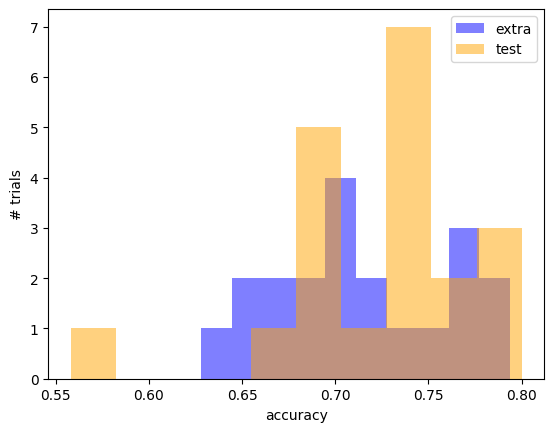

In [24]:
plt.hist(extra_accuracies, label='extra', color='blue',   alpha=0.5)
plt.hist(test_accuracies,  label='test',  color='orange', alpha=0.5)
plt.xlabel('accuracy')
plt.ylabel('# trials')
plt.legend();

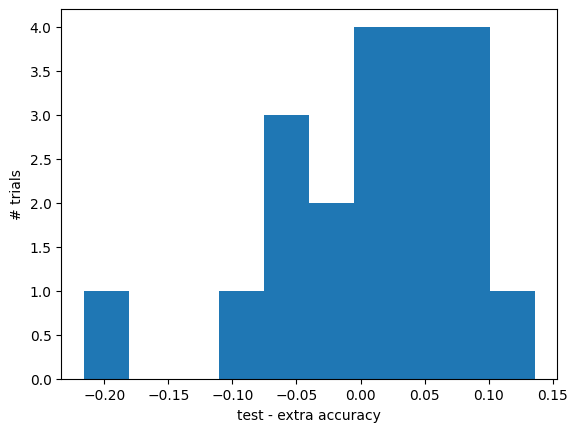

In [27]:
plt.hist(test_accuracies - extra_accuracies)
plt.xlabel('test - extra accuracy')
plt.ylabel('# trials');

In [26]:
(test_accuracies - extra_accuracies).mean()

0.00500000000000001